# 论文7: 使用深度卷积神经网络进行ImageNet分类
## Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton (2012)

### AlexNet：开启深度学习革命的CNN

AlexNet以15.3%的前5误差率赢得了ImageNet 2012，粉碎了比赛（26.2%）。这篇论文重新点燃了对深度学习的兴趣。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 卷积层实现

CNN的核心构建块

In [2]:
def relu(x):
    return np.maximum(0, x)

def conv2d(input_image, kernel, stride=1, padding=0):
    """
    2D Convolution operation
    
    input_image: (H, W) or (C, H, W)
    kernel: (out_channels, in_channels, kH, kW)
    """
    if len(input_image.shape) == 2:
        input_image = input_image[np.newaxis, :, :]
    
    in_channels, H, W = input_image.shape
    out_channels, _, kH, kW = kernel.shape
    
    # Add padding
    if padding > 0:
        input_padded = np.pad(input_image, 
                             ((0, 0), (padding, padding), (padding, padding)), 
                             mode='constant')
    else:
        input_padded = input_image
    
    # Output dimensions
    out_H = (H + 2*padding - kH) // stride + 1
    out_W = (W + 2*padding - kW) // stride + 1
    
    output = np.zeros((out_channels, out_H, out_W))
    
    # Perform convolution
    for oc in range(out_channels):
        for i in range(out_H):
            for j in range(out_W):
                h_start = i * stride
                w_start = j * stride
                
                # Extract patch
                patch = input_padded[:, h_start:h_start+kH, w_start:w_start+kW]
                
                # Convolve with kernel
                output[oc, i, j] = np.sum(patch * kernel[oc])
    
    return output

def max_pool2d(input_image, pool_size=2, stride=2):
    """
    Max pooling operation
    """
    C, H, W = input_image.shape
    
    out_H = (H - pool_size) // stride + 1
    out_W = (W - pool_size) // stride + 1
    
    output = np.zeros((C, out_H, out_W))
    
    for c in range(C):
        for i in range(out_H):
            for j in range(out_W):
                h_start = i * stride
                w_start = j * stride
                
                pool_region = input_image[c, h_start:h_start+pool_size, 
                                         w_start:w_start+pool_size]
                output[c, i, j] = np.max(pool_region)
    
    return output

# Test convolution
test_image = np.random.randn(1, 8, 8)
test_kernel = np.random.randn(3, 1, 3, 3) * 0.1

conv_output = conv2d(test_image, test_kernel, stride=1, padding=1)
print(f"Input shape: {test_image.shape}")
print(f"Kernel shape: {test_kernel.shape}")
print(f"Conv output shape: {conv_output.shape}")

pooled = max_pool2d(conv_output, pool_size=2, stride=2)
print(f"After max pooling: {pooled.shape}")

Input shape: (1, 8, 8)
Kernel shape: (3, 1, 3, 3)
Conv output shape: (3, 8, 8)
After max pooling: (3, 4, 4)


## AlexNet架构（简化版）

原始：227x227x3 → 5个卷积层 → 3个全连接层 → 1000个类别

我们的简化版本，用于32x32图像

In [3]:
class AlexNetSimplified:
    def __init__(self, num_classes=10):
        """
        Simplified AlexNet for 32x32 images (like CIFAR-10)
        
        Architecture:
        - Conv1: 3x3x3 -> 32 filters
        - MaxPool
        - Conv2: 32 -> 64 filters
        - MaxPool
        - Conv3: 64 -> 128 filters
        - FC layers
        """
        # Conv layers
        self.conv1_filters = np.random.randn(32, 3, 3, 3) * 0.01
        self.conv1_bias = np.zeros(32)
        
        self.conv2_filters = np.random.randn(64, 32, 3, 3) * 0.01
        self.conv2_bias = np.zeros(64)
        
        self.conv3_filters = np.random.randn(128, 64, 3, 3) * 0.01
        self.conv3_bias = np.zeros(128)
        
        # FC layers (after conv: 128 * 4 * 4 = 2048)
        self.fc1_weights = np.random.randn(2048, 512) * 0.01
        self.fc1_bias = np.zeros(512)
        
        self.fc2_weights = np.random.randn(512, num_classes) * 0.01
        self.fc2_bias = np.zeros(num_classes)
    
    def forward(self, x, use_dropout=False, dropout_rate=0.5):
        """
        Forward pass
        x: (3, 32, 32) image
        """
        # Conv1 + ReLU + MaxPool
        conv1 = conv2d(x, self.conv1_filters, stride=1, padding=1)
        conv1 += self.conv1_bias[:, np.newaxis, np.newaxis]
        conv1 = relu(conv1)
        pool1 = max_pool2d(conv1, pool_size=2, stride=2)  # 32 x 16 x 16
        
        # Conv2 + ReLU + MaxPool
        conv2 = conv2d(pool1, self.conv2_filters, stride=1, padding=1)
        conv2 += self.conv2_bias[:, np.newaxis, np.newaxis]
        conv2 = relu(conv2)
        pool2 = max_pool2d(conv2, pool_size=2, stride=2)  # 64 x 8 x 8
        
        # Conv3 + ReLU + MaxPool
        conv3 = conv2d(pool2, self.conv3_filters, stride=1, padding=1)
        conv3 += self.conv3_bias[:, np.newaxis, np.newaxis]
        conv3 = relu(conv3)
        pool3 = max_pool2d(conv3, pool_size=2, stride=2)  # 128 x 4 x 4
        
        # Flatten
        flattened = pool3.reshape(-1)
        
        # FC1 + ReLU + Dropout
        fc1 = np.dot(flattened, self.fc1_weights) + self.fc1_bias
        fc1 = relu(fc1)
        
        if use_dropout:
            dropout_mask = (np.random.rand(*fc1.shape) > dropout_rate).astype(float)
            fc1 = fc1 * dropout_mask / (1 - dropout_rate)
        
        # FC2 (output)
        output = np.dot(fc1, self.fc2_weights) + self.fc2_bias
        
        return output

# Create model
alexnet = AlexNetSimplified(num_classes=10)
print("AlexNet (simplified) created")

# Test forward pass
test_img = np.random.randn(3, 32, 32)
output = alexnet.forward(test_img)
print(f"Input: (3, 32, 32)")
print(f"Output: {output.shape} (class scores)")

AlexNet (simplified) created
Input: (3, 32, 32)
Output: (10,) (class scores)


## 生成合成图像数据

Training set: (200, 3, 32, 32)
Test set: (50, 3, 32, 32)


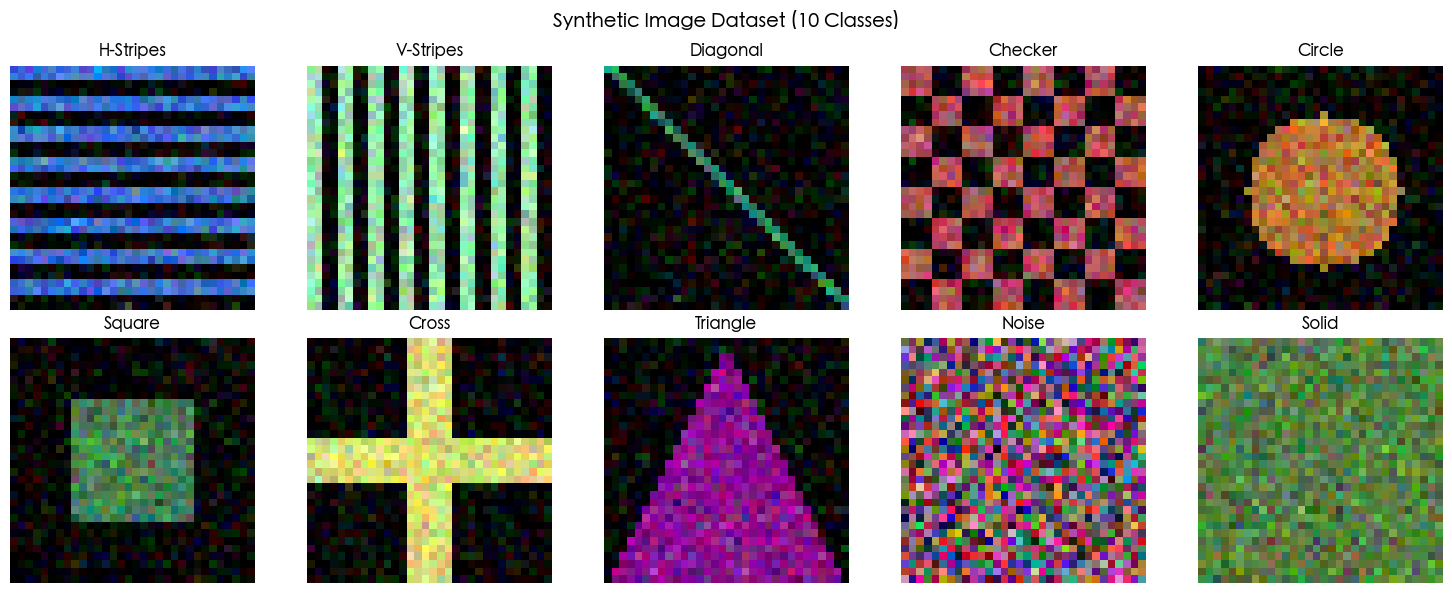

In [4]:
def generate_simple_images(num_samples=100, image_size=32):
    """
    Generate simple synthetic images with different patterns
    Classes:
    0: Horizontal stripes
    1: Vertical stripes
    2: Diagonal stripes
    3: Checkerboard
    4: Circle
    5: Square
    6: Cross
    7: Triangle
    8: Random noise
    9: Solid color
    """
    X = []
    y = []
    
    for i in range(num_samples):
        class_label = i % 10
        img = np.zeros((3, image_size, image_size))
        
        if class_label == 0:  # Horizontal stripes
            for row in range(0, image_size, 4):
                img[:, row:row+2, :] = 1
        
        elif class_label == 1:  # Vertical stripes
            for col in range(0, image_size, 4):
                img[:, :, col:col+2] = 1
        
        elif class_label == 2:  # Diagonal
            for i in range(image_size):
                if i < image_size:
                    img[:, i, i] = 1
                    if i+1 < image_size:
                        img[:, i, i+1] = 1
        
        elif class_label == 3:  # Checkerboard
            for i in range(0, image_size, 4):
                for j in range(0, image_size, 4):
                    if (i//4 + j//4) % 2 == 0:
                        img[:, i:i+4, j:j+4] = 1
        
        elif class_label == 4:  # Circle
            center = image_size // 2
            radius = image_size // 3
            y_grid, x_grid = np.ogrid[:image_size, :image_size]
            mask = (x_grid - center)**2 + (y_grid - center)**2 <= radius**2
            img[:, mask] = 1
        
        elif class_label == 5:  # Square
            margin = image_size // 4
            img[:, margin:-margin, margin:-margin] = 1
        
        elif class_label == 6:  # Cross
            mid = image_size // 2
            thickness = 3
            img[:, mid-thickness:mid+thickness, :] = 1
            img[:, :, mid-thickness:mid+thickness] = 1
        
        elif class_label == 7:  # Triangle
            for i in range(image_size):
                width = int((i / image_size) * image_size / 2)
                start = image_size // 2 - width
                end = image_size // 2 + width
                img[:, i, start:end] = 1
        
        elif class_label == 8:  # Random noise
            img = np.random.rand(3, image_size, image_size)
        
        else:  # Solid
            img[:] = 0.7
        
        # Add color variation
        color = np.random.rand(3, 1, 1)
        img = img * color
        
        # Add noise
        img += np.random.randn(3, image_size, image_size) * 0.1
        img = np.clip(img, 0, 1)
        
        X.append(img)
        y.append(class_label)
    
    return np.array(X), np.array(y)

# Generate dataset
X_train, y_train = generate_simple_images(200)
X_test, y_test = generate_simple_images(50)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Visualize samples
class_names = ['H-Stripes', 'V-Stripes', 'Diagonal', 'Checker', 'Circle', 
               'Square', 'Cross', 'Triangle', 'Noise', 'Solid']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    # Find first occurrence of each class
    idx = np.where(y_train == i)[0][0]
    img = X_train[idx].transpose(1, 2, 0)  # CHW -> HWC
    axes[i].imshow(img)
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

plt.suptitle('Synthetic Image Dataset (10 Classes)', fontsize=14)
plt.tight_layout()
plt.show()

## 数据增强

AlexNet广泛使用了数据增强——这是一个关键创新

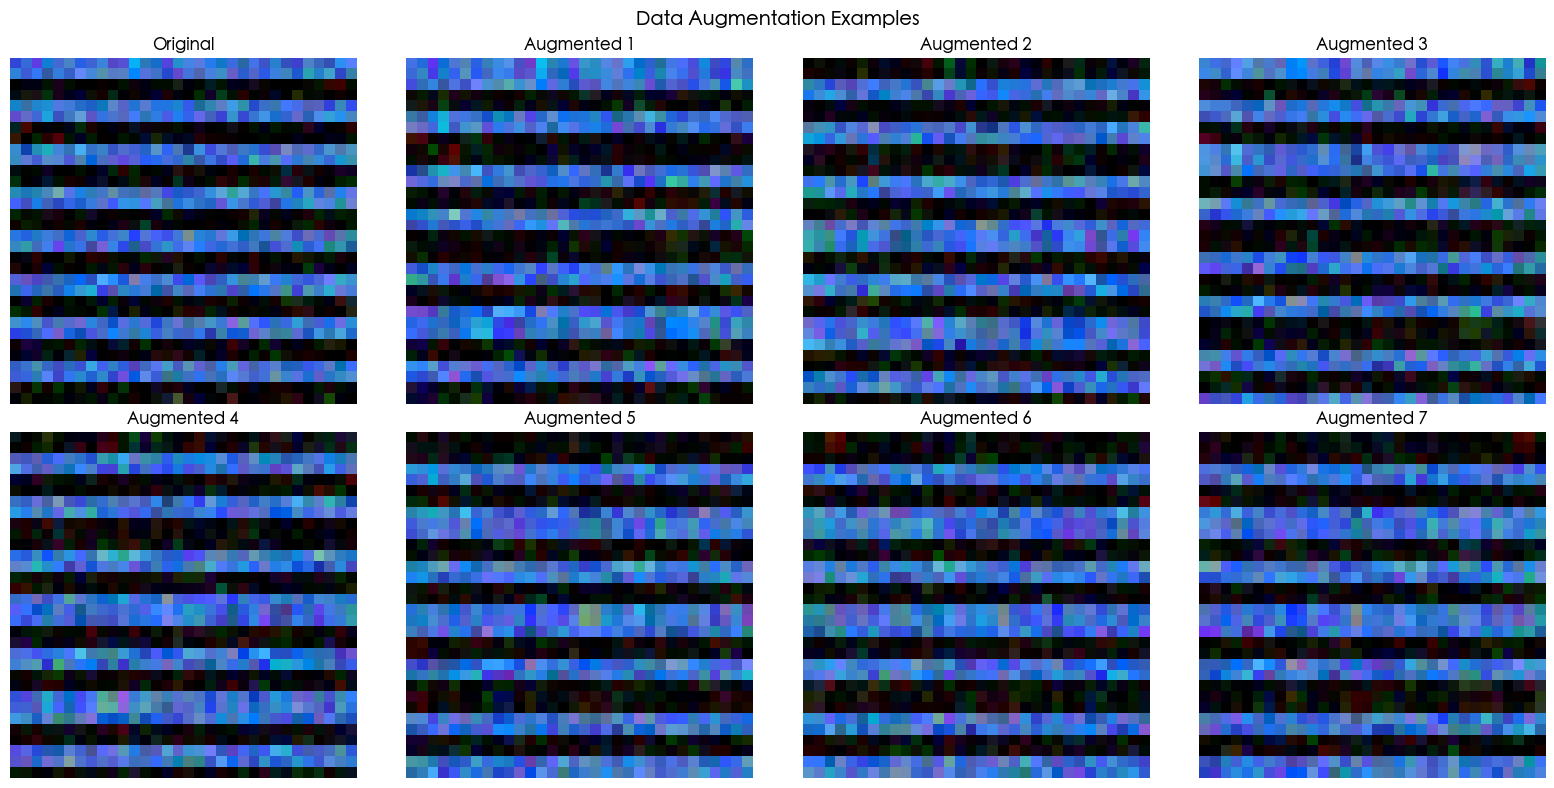

In [5]:
def random_flip(img):
    """Horizontal flip"""
    if np.random.rand() > 0.5:
        return img[:, :, ::-1].copy()
    return img

def random_crop(img, crop_size=28):
    """Random crop"""
    _, h, w = img.shape
    top = np.random.randint(0, h - crop_size + 1)
    left = np.random.randint(0, w - crop_size + 1)
    
    cropped = img[:, top:top+crop_size, left:left+crop_size]
    
    # Resize back to original
    # Simple nearest neighbor (for demo)
    scale_h = h / crop_size
    scale_w = w / crop_size
    
    resized = np.zeros_like(img)
    for i in range(h):
        for j in range(w):
            src_i = min(int(i / scale_h), crop_size - 1)
            src_j = min(int(j / scale_w), crop_size - 1)
            resized[:, i, j] = cropped[:, src_i, src_j]
    
    return resized

def add_noise(img, noise_level=0.05):
    """Add Gaussian noise"""
    noise = np.random.randn(*img.shape) * noise_level
    return np.clip(img + noise, 0, 1)

def augment_image(img):
    """Apply random augmentations"""
    img = random_flip(img)
    img = random_crop(img)
    img = add_noise(img)
    return img

# Demonstrate augmentation
original = X_train[0]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0, 0].imshow(original.transpose(1, 2, 0))
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for i in range(1, 8):
    augmented = augment_image(original.copy())
    row = i // 4
    col = i % 4
    axes[row, col].imshow(augmented.transpose(1, 2, 0))
    axes[row, col].set_title(f'Augmented {i}')
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=14)
plt.tight_layout()
plt.show()

## 可视化学习到的滤波器

AlexNet的见解之一：可视化网络学到了什么

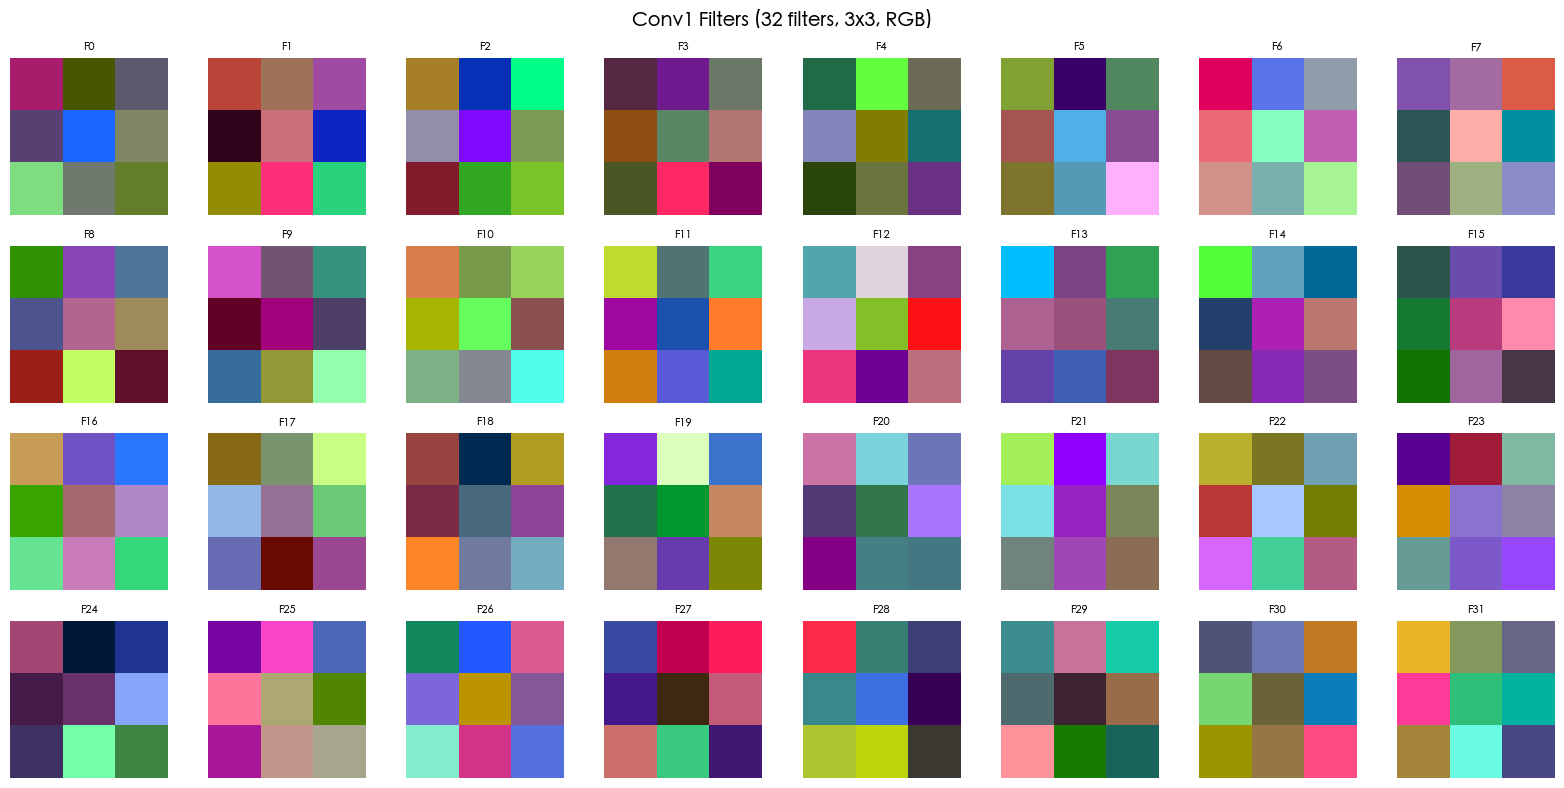

These filters learn to detect edges, colors, and simple patterns


In [6]:
# Visualize first layer filters
filters = alexnet.conv1_filters  # Shape: (32, 3, 3, 3)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(32, len(axes))):
    # Normalize filter for visualization
    filt = filters[i].transpose(1, 2, 0)  # CHW -> HWC
    filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)
    
    axes[i].imshow(filt)
    axes[i].axis('off')
    axes[i].set_title(f'F{i}', fontsize=8)

plt.suptitle('Conv1 Filters (32 filters, 3x3, RGB)', fontsize=14)
plt.tight_layout()
plt.show()

print("These filters learn to detect edges, colors, and simple patterns")

## 特征图可视化

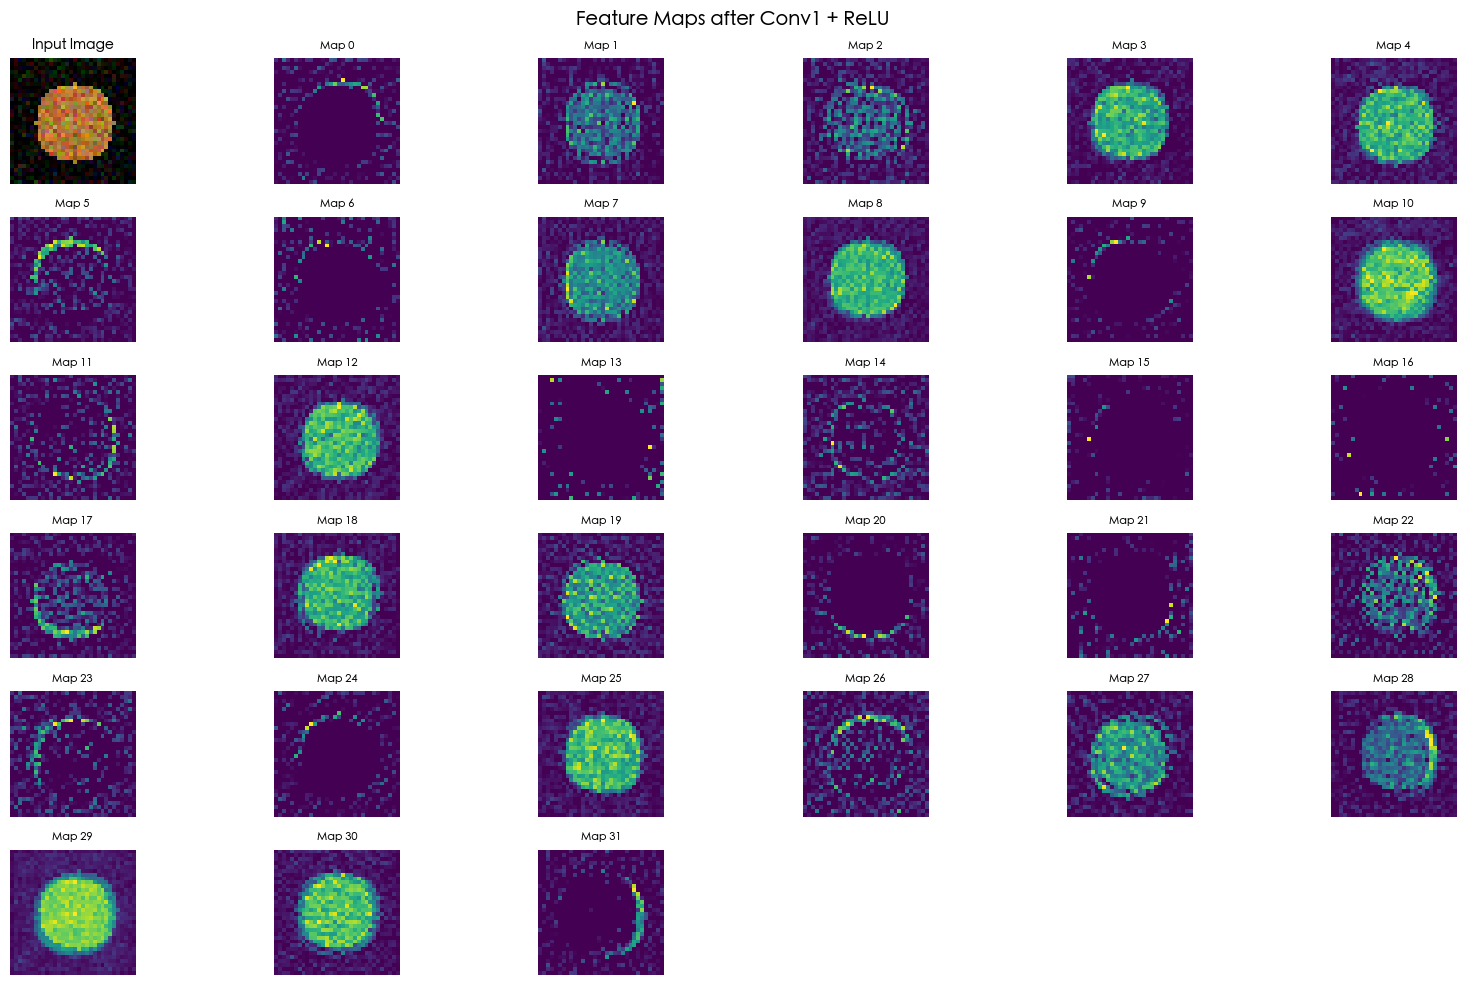

Different feature maps respond to different patterns in the image


In [7]:
# Process an image and visualize feature maps
test_image = X_train[4]  # Circle

# Forward through first conv layer
conv1_output = conv2d(test_image, alexnet.conv1_filters, stride=1, padding=1)
conv1_output += alexnet.conv1_bias[:, np.newaxis, np.newaxis]
conv1_output = relu(conv1_output)

# Visualize
fig = plt.figure(figsize=(16, 10))

# Original image
ax = plt.subplot(6, 6, 1)
ax.imshow(test_image.transpose(1, 2, 0))
ax.set_title('Input Image', fontsize=10)
ax.axis('off')

# Feature maps
for i in range(min(32, 35)):
    ax = plt.subplot(6, 6, i+2)
    ax.imshow(conv1_output[i], cmap='viridis')
    ax.set_title(f'Map {i}', fontsize=8)
    ax.axis('off')

plt.suptitle('Feature Maps after Conv1 + ReLU', fontsize=14)
plt.tight_layout()
plt.show()

print("Different feature maps respond to different patterns in the image")

## 测试分类

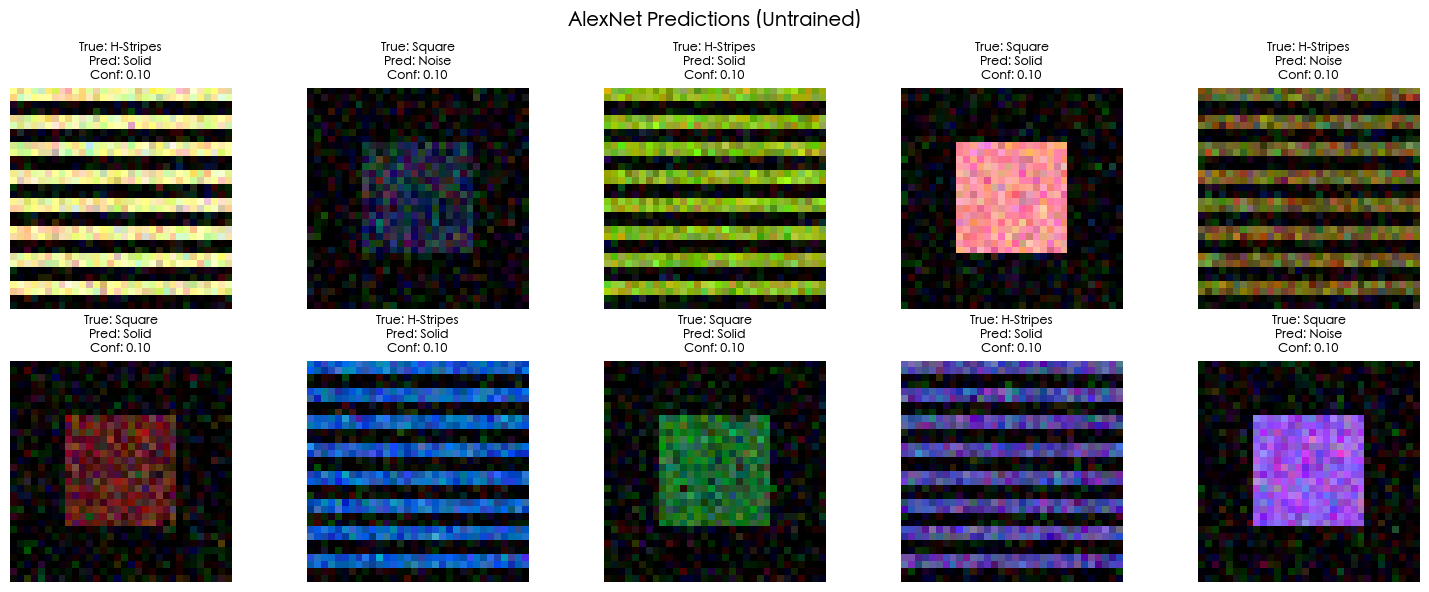

Note: Model is untrained, so predictions are random!
Training would require gradient descent, which we've simplified for clarity.


In [8]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum()

# Test on a few images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    idx = i * 5  # Sample every 5th image
    img = X_test[idx]
    true_label = y_test[idx]
    
    # Forward pass
    logits = alexnet.forward(img, use_dropout=False)
    probs = softmax(logits)
    pred_label = np.argmax(probs)
    
    # Display
    axes[i].imshow(img.transpose(1, 2, 0))
    axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {probs[pred_label]:.2f}',
                     fontsize=9)
    axes[i].axis('off')

plt.suptitle('AlexNet Predictions (Untrained)', fontsize=14)
plt.tight_layout()
plt.show()

print("Note: Model is untrained, so predictions are random!")
print("Training would require gradient descent, which we've simplified for clarity.")

## 关键要点

### AlexNet创新（2012）：

1. **ReLU激活**：比sigmoid/tanh快得多
   - 正值无饱和
   - 训练更快（比tanh快6倍）

2. **Dropout**：强大的正则化
   - 防止过拟合
   - 在FC层中使用（0.5比率）

3. **数据增强**： 
   - 随机裁剪和翻转
   - 颜色抖动
   - 人为增加数据集大小

4. **GPU训练**： 
   - 使用2块GTX 580 GPU
   - 使深度网络训练成为可能

5. **局部响应归一化（LRN）**：
   - 特征图之间的侧向抑制
   - 现在不太常见（Batch Norm取代了它）

### 架构：
```
输入 (227x227x3)
  ↓
Conv1 (96个滤波器, 11x11, 步长4) + ReLU + MaxPool
  ↓
Conv2 (256个滤波器, 5x5) + ReLU + MaxPool
  ↓
Conv3 (384个滤波器, 3x3) + ReLU
  ↓
Conv4 (384个滤波器, 3x3) + ReLU
  ↓
Conv5 (256个滤波器, 3x3) + ReLU + MaxPool
  ↓
FC6 (4096) + ReLU + Dropout
  ↓
FC7 (4096) + ReLU + Dropout
  ↓
FC8 (1000个类别) + Softmax
```

### 影响：
- **赢得ImageNet 2012**：15.3%前5误差率（vs第二名的26.2%）
- **重新点燃深度学习**：证明了深度+数据+计算有效
- **GPU革命**：使GPU成为深度学习的必需品
- **启发了现代CNN**：VGG、ResNet等都建立在这些想法之上

### 为什么有效：
1. 深度架构（2012年8层已经很深了！）
2. 大型数据集（120万张ImageNet图像）
3. GPU加速（使训练成为可能）
4. 智能正则化（dropout + 数据增强）
5. ReLU激活（更快训练）

### 现代视角：
- AlexNet现在被认为是"简单"的
- ResNet有100+层
- Batch Norm取代了LRN
- 但核心思想仍然存在：
  - 深度层次特征
  - 卷积用于空间结构
  - 数据增强
  - 正则化